# Deduplication

In [1]:
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import sqlalchemy
from collections import Counter
import datetime
from __future__ import division
CONFIG_PATH = 'database.yml'
sns.set(color_codes=True)
%matplotlib inline
import collections
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
with open(CONFIG_PATH) as f:
    config = yaml.load(f)
engine = sqlalchemy.create_engine('postgres://', connect_args=config)

/Users/mbauman/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


192191/194130 (99.0011847731%) records matched


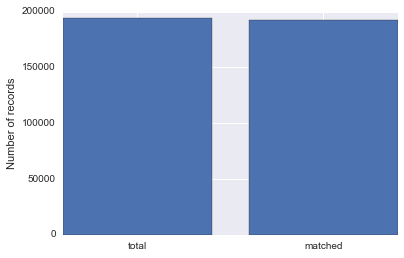

In [102]:
# Number of records/identities:
tot = engine.execute('SELECT count(*) from dedupe.entries').fetchone()[0]
uniq = engine.execute('SELECT count(*) from dedupe.entries_unique').fetchone()[0]
tot_matched = engine.execute('SELECT count(dedupe_id) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [tot,tot_matched],tick_label=['total','matched'],align='center');
plt.ylabel("Number of records");

print("{}/{} ({}%) records matched".format(tot_matched, tot, 100*tot_matched/tot))

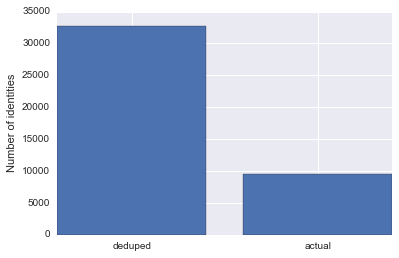

In [103]:
dedup = engine.execute('SELECT count(distinct dedupe_id) from dedupe.entries').fetchone()[0]
actual = engine.execute('SELECT count(distinct uuid) from dedupe.entries').fetchone()[0]
plt.bar(range(2), [dedup,actual],tick_label=['deduped','actual'],align='center');
plt.ylabel("Number of identities");

# Falsely merged persons

In [117]:
df = pd.read_sql('SELECT dedupe_id, count(distinct uuid) from dedupe.entries where dedupe_id is not null group by dedupe_id', engine)
print("{} falsely merged identities; {}% of all identities".format(sum(df['count'] > 1), 100*sum(df['count'] > 1)/actual))

164 falsely merged identities; 1.72341319882% of all identities


In [129]:
dups = df[df['count'] > 1].dedupe_id
# Many are twins with off-by-one SSNs
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[14]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,d92b4f74-a73c-48d3-b548-2b6bc55f7f3b,Rhonda,Davis,691-50-2398,F,1967-06-14,asian,nonhispanic,186315,Rhonda Davis,3466
1,d92b4f74-a73c-48d3-b548-2b6bc55f7f3b,Rhonda,Davis,691-50-2398,F,1967-03-07,asian,nonhispanic,186316,Rhonda Davis,3466
2,e7e57ae1-47d7-46f8-9a90-5144a05812ed,Mary,Davis,691-50-2397,F,1967-06-14,asian,None,5005,Mary Davis,3466
3,d92b4f74-a73c-48d3-b548-2b6bc55f7f3b,Rhonda,Davis,691-50-2398,F,1967-06-14,amindian,None,186317,Rhonda Davis,3466


In [113]:
# Some are just really similar:
pd.read_sql('SELECT * FROM dedupe.entries WHERE dedupe_id = {}'.format(dups.iloc[4]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,53c8e80d-6931-4adc-b5fb-e05412b3c107,David,Johnson,None,M,1967-03-07,None,nonhispanic,27226,David Johnson,732
1,dbe5a319-d61f-46a0-b588-96a4908a37e8,David,Johnson,None,M,1964-02-16,white,nonhispanic,106995,David Johnson,732


# Split identities

In [130]:
# Number of persons that got split into two identities
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) from dedupe.entries group by uuid', engine)
sum(df['count'] > 1)

7398

In [133]:
splits = df[df['count'] > 1].uuid
# Some of these are very obvious, and should have been captured:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(splits.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powebl,080-64-6896,F,1983-06-19,black,nonhispanic,111346,Lisa Powebl,16782
1,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powell,080-64-6896,F,1983-06-19,black,nonhispanic,111347,Lisa Powell,16782
2,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Liz,Powell,None,F,1983-06-19,black,nonhispanic,111351,Liz Powell,6335
3,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powell,080-64-6896,F,1983-06-19,None,None,111348,Lisa Powell,16782
4,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lika,Powell,080-64-6896,F,1983-12-08,None,nonhispanic,111350,Lika Powell,14028
5,000bd9f1-0ae8-482b-84a2-34dcf773a9b1,Lisa,Powell,080-64-6896,None,1983-06-19,asian,None,111349,Lisa Powell,16782


# Ignored persons

In [134]:
# Number of persons that were ignored entirely
sum(df['count'] == 0)

6

In [136]:
ignores = df[df['count'] == 0].uuid
# These records simply had insufficient data:
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(ignores.iloc[0]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,1472ca98-8eb1-48ac-b568-da2ca475fd3c,Marcia,Perry,None,F,None,amindian,nonhispanic,24093,Marcia Perry,None


# Incomplete persons

In [137]:
df = pd.read_sql('SELECT uuid, count(distinct dedupe_id) as identities, count(dedupe_id)*1.0/count(*) as completeness from dedupe.entries group by uuid', engine)
sum(df[(df.identities == 1)].completeness < 1)

137

In [141]:
incompletes = df[(df.identities == 1) & (df.completeness < 1)].uuid
# Like above, these persons just had some records with insufficient data
pd.read_sql("SELECT * FROM dedupe.entries WHERE uuid = '{}'".format(incompletes.iloc[1]), engine)

,uuid,first_name,last_name,ssn,sex,dob,race,ethnicity,entry_id,full_name,dedupe_id
0,088ef095-d3cb-4c63-809c-ce2d960e47d8,Kurt,Suarez,418-63-5361,M,1973-02-07,None,None,106689,Kurt Suarez,10224.0
1,088ef095-d3cb-4c63-809c-ce2d960e47d8,Kurt,Suarez,None,M,None,white,nonhispanic,106691,Kurt Suarez,NaN
2,088ef095-d3cb-4c63-809c-ce2d960e47d8,Kurt,Suarez,418-63-5361,M,1973-02-07,white,None,106690,Kurt Suarez,10224.0
